# 네이버 영화리뷰 감성분석

In [1]:
import konlpy
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# STEP 1. 데이터 준비

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [3]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


# STEP 2. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.  
그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

## 2.1 훈련용, 테스트용 데이터셋 분리 & word_to_index 단어 사전 생성

In [4]:
from konlpy.tag import Mecab                # 형태소 분석기
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)   # Train 데이터 중복 제거
    train_data = train_data.dropna(how = 'any')                     # Train 데이터 결측치 제거 
    test_data.drop_duplicates(subset=['document'], inplace=True)    # Test 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')                       # Test 데이터 결측치 제거
                                                                    # ‘any’ : If any NA values are present, drop that row or column.
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)                         # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)                         # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()                        # 토큰화된 단어들을 하나의 리스트로 합치기
    counter = Counter(words)                                        # 단어 개수 세기
                                                                    # Counter object반환(딕셔너리 형태)
    counter = counter.most_common(num_words - 4)                    # 빈도수 높은 순서대로 단어와 횟수 정보 리턴(튜플을 원소로한 리스트 형태)                 
                                                                    # 참고 : https://docs.python.org/3/library/collections.html#collections.Counter.most_common
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # word_to_index 사전 구성
        
    def wordlist_to_indexlist(wordlist):                            # 문장에서 분리된 단어들을 인덱스로 변환
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))             # 문장에서 분리된 단어들을 인덱스로 변환
    X_test = list(map(wordlist_to_indexlist, X_test))               # 문장에서 분리된 단어들을 인덱스로 변환
    
    y_train = np.array(list(train_data['label']))                   # 정답지인 긍정, 부정 
    y_test = np.array(list(test_data['label']))                     # 정답지인 긍정, 부정 
        
    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
# 개수 프린트해보기
print("X_train 개수: ", len(X_train))
print("y_train 개수: ",len(y_train))
print("X_test 개수: ",len(X_test))
print("y_test 개수: ",len(y_test))

print("\nword_to_index 개수: ",len(word_to_index))

X_train 개수:  146182
y_train 개수:  146182
X_test 개수:  49157
y_test 개수:  49157

word_to_index 개수:  9997


## 2.2 index_to_word 단어 사전 생성

In [6]:
# 디코딩용 index_to_word 사전 만들기
index_to_word = {index:word for word, index in word_to_index.items()}

## 2.3 인코더 & 디코더 함수 정의

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# STEP 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


## 3.1 인덱스 0 - 3번까지 "PAD, BOS, UNK, UNUSED" 넣기 

In [8]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index[''])    # 3이 출력됩니다. 
print(index_to_word[4])     # '.' 가 출력됩니다.

<BOS>
3
.


In [9]:
# 디코드해보기
print(get_decoded_sentence(X_train[1], index_to_word))
print('라벨: ', y_train[1])                             # 1번째 리뷰데이터의 라벨

. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1


## 3.2 데이터셋 내 문장 길이 분포

In [10]:
total_data_text = list(X_train) + list(X_test)


# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]  # num_tokens: [문장의 단어 개수, 문장의 단어 개수, 문장의 단어 개수, ...]
num_tokens = np.array(num_tokens)


# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


## 3.3 적절한 최대 문장 길이 지정

In [11]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)

## ?? 아래 문장이 이해가 안됨. 왜 각 문장의 단어 개수에 총 문장의 개수를 나눔? 그 결과 무슨 의미인가?
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))    # len(num_tokens) : 문장의 개수

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## 3.4 패딩 추가

In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [13]:
# 확인용
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

# STEP 4. Validation set 구성

In [14]:
# validation set 30,000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116,182건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# STEP 5. 모델 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

## (1) 1D-CNN 모델

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### 모델 훈련 개시

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 4s 6ms/step - loss: 0.4994 - accuracy: 0.7535 - val_loss: 0.3537 - val_accuracy: 0.8474
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3209 - accuracy: 0.8643 - val_loss: 0.3401 - val_accuracy: 0.8552
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2733 - accuracy: 0.8882 - val_loss: 0.3465 - val_accuracy: 0.8491
Epoch 4/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2281 - accuracy: 0.9102 - val_loss: 0.3567 - val_accuracy: 0.8517
Epoch 5/10
227/227 [==============================] - 1s 5ms/step - loss: 0.1798 - accuracy: 0.9334 - val_loss: 0.3945 - val_accuracy: 0.8479
Epoch 6/10
227/227 [==============================] - 1s 5ms/step - loss: 0.1358 - accuracy: 0.9525 - val_loss: 0.4506 - val_accuracy: 0.8412
Epoch 7/10
227/227 [==============================] - 1s 5ms/step - loss: 0.1018 - accuracy: 0.9662 - val_loss: 0.5138 - val_accuracy: 0.8429
Epoch 

### 성능 평가

In [17]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7419 - accuracy: 0.8272
[0.7419492602348328, 0.8271660208702087]


### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


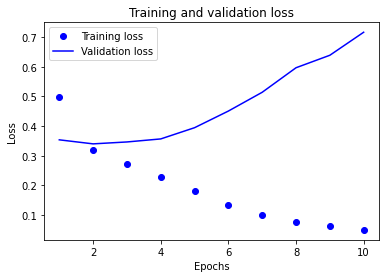

In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

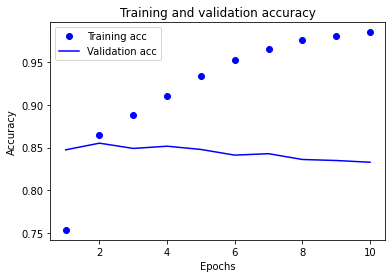

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 지금까지 학습된 Embedding 레이어 분석

In [20]:
# Embedding Layer의 가중치 파라미터
embedding_layer = model.layers[0]              # 위에서 나열한 레이어 중에 0번째 레이어 = embedding layer
weights = embedding_layer.get_weights()[0]     # embedding layer의 가중치들 얻기


print('Weights Shape: ', weights.shape)        # shape: (vocab_size, embedding_dim)
print('\nWeights 출력: \n', weights) 

Weights Shape:  (10000, 32)

Weights 출력: 
 [[-9.0327198e-03  1.7517167e-03  7.1345903e-02 ... -3.1417217e-02
   1.4198201e-02  6.6370875e-02]
 [ 2.2895847e-02  3.6668751e-02  4.1398037e-02 ...  3.6895324e-02
   9.9219382e-05  2.3389962e-02]
 [-1.5073657e-02  2.6791301e-02 -2.9295087e-03 ...  8.6443536e-03
  -4.4370592e-02 -3.8826384e-02]
 ...
 [ 1.0990044e-01  2.6086336e-02  4.5303304e-02 ... -5.4414362e-02
   6.5518871e-02  1.1370488e-01]
 [ 5.1919773e-02 -1.1123980e-01  1.4101575e-01 ... -1.3226864e-01
   1.2767205e-01  4.1913299e-04]
 [ 2.3563009e-02 -5.1730839e-03  4.6340622e-02 ...  9.7332969e-02
  -2.3165228e-02 -1.3640499e-02]]


In [21]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_old_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_old_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))        # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
                                                                # 8-8에서 인덱스 0부터 3까지 <pad>, <bos>, <unk>, <unused> 4가지를 제외하기 위해 4를 뺌
                                                                # word_vector_dim: 임베딩 벡터의 차원수

# 단어 개수(에서 8-8의 <pad>, <bos>, <unk>, <unused> 문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]                                # embedding layer의 가중치들
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 **임베딩 파라미터 파일**을 읽어서 word vector로 활용할 수 있음

In [22]:
# 만들어 놓은 임베딩 파라미터 파일을 불러오기
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_old_file_path, binary=False)

# 임베딩 한 단어의 워드 벡터 출력해보기
vector = word_vectors['사랑']
vector

array([-0.06007011,  0.03364957, -0.02707294, -0.02619197,  0.02412084,
       -0.04143812,  0.00547191, -0.0749346 ,  0.02420989, -0.10781509,
        0.03025507,  0.09613515, -0.08594567, -0.05262685, -0.03811287,
       -0.03213146,  0.05219866,  0.02431271,  0.11358693, -0.083206  ,
       -0.04752585, -0.04428297,  0.01203178, -0.05098534,  0.00507641,
        0.07530769,  0.02353247,  0.06021843, -0.09197139,  0.02776559,
        0.00939828, -0.00237544], dtype=float32)

In [23]:
# 유의어와 유사도 출력해보기
word_vectors.similar_by_word('사랑')

[('정점', 0.8060023188591003),
 ('피터팬', 0.8001174330711365),
 ('누군가', 0.7567253708839417),
 ('넘사벽', 0.7460497617721558),
 ('제니', 0.7432783842086792),
 ('앓', 0.7349708676338196),
 ('멋져요', 0.7344741821289062),
 ('전두환', 0.7339342832565308),
 ('*^^*', 0.7334235310554504),
 ('주어진', 0.7302190065383911)]

> 사랑과 유의어를 출력해보니 유의어는 사랑과 관련성이 거의 없으며 유사도는 '정점'이 가장 높다

## (2) RNN

In [24]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 개시

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 3s 7ms/step - loss: 0.5677 - accuracy: 0.7340 - val_loss: 0.4821 - val_accuracy: 0.8382
Epoch 2/10
227/227 [==============================] - 1s 6ms/step - loss: 0.4522 - accuracy: 0.8490 - val_loss: 0.4472 - val_accuracy: 0.8429
Epoch 3/10
227/227 [==============================] - 1s 6ms/step - loss: 0.4117 - accuracy: 0.8607 - val_loss: 0.4275 - val_accuracy: 0.8442
Epoch 4/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3837 - accuracy: 0.8676 - val_loss: 0.4130 - val_accuracy: 0.8426
Epoch 5/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3616 - accuracy: 0.8743 - val_loss: 0.4057 - val_accuracy: 0.8465
Epoch 6/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3424 - accuracy: 0.8803 - val_loss: 0.3982 - val_accuracy: 0.8469
Epoch 7/10
227/227 [==============================] - 1s 6ms/step - loss: 0.3255 - accuracy: 0.8867 - val_loss: 0.3918 - val_accuracy: 0.8482
Epoch 

### 성능 평가

In [26]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4050 - accuracy: 0.8423
[0.4049597382545471, 0.842321515083313]


### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


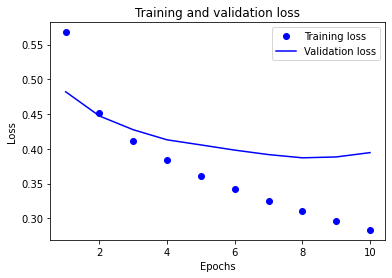

In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

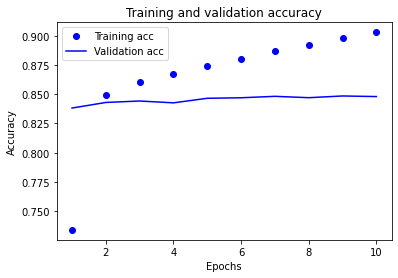

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 지금까지 학습된 Embedding 레이어 분석

In [29]:
# Embedding Layer의 가중치 파라미터
embedding_layer = model.layers[0]              # 위에서 나열한 레이어 중에 0번째 레이어 = embedding layer
weights = embedding_layer.get_weights()[0]     # embedding layer의 가중치들 얻기


print('Weights Shape: ', weights.shape)        # shape: (vocab_size, embedding_dim)
print('\nWeights 출력: \n', weights) 

Weights Shape:  (10000, 32)

Weights 출력: 
 [[-0.02414362 -0.0253279  -0.01160519 ...  0.02046078 -0.05777333
  -0.08731849]
 [-0.00029299 -0.01987867  0.04751175 ...  0.0046156  -0.01462722
  -0.04097886]
 [ 0.03559721  0.0456277  -0.03142913 ...  0.03138539  0.0240561
   0.00924603]
 ...
 [ 0.08897808  0.00296329  0.06767903 ...  0.07985311  0.01264867
  -0.02881915]
 [ 0.12047789 -0.06612647  0.03096695 ...  0.08844548 -0.05393435
  -0.06432808]
 [ 0.02240426 -0.01880679 -0.003893   ... -0.03046754  0.01196506
  -0.00723326]]


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_old_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_old_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))        # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
                                                                # 8-8에서 인덱스 0부터 3까지 <pad>, <bos>, <unk>, <unused> 4가지를 제외하기 위해 4를 뺌
                                                                # word_vector_dim: 임베딩 벡터의 차원수

# 단어 개수(에서 8-8의 <pad>, <bos>, <unk>, <unused> 문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]                                # embedding layer의 가중치들
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 **임베딩 파라미터 파일**을 읽어서 word vector로 활용할 수 있음

In [31]:
# 만들어 놓은 임베딩 파라미터 파일을 불러오기
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_old_file_path, binary=False)

# 임베딩 한 단어의 워드 벡터 출력해보기
vector = word_vectors['사랑']
vector

array([-0.11175463,  0.08620043, -0.11652824,  0.05209618, -0.10500228,
        0.06538889,  0.12810735,  0.07521391,  0.09933542,  0.10642616,
        0.07226558, -0.05144704,  0.10355746, -0.02099694, -0.00275429,
        0.10805435,  0.09634042,  0.13233536, -0.11742035, -0.04561586,
        0.08633053,  0.10945699,  0.01822608,  0.0803242 ,  0.0324721 ,
       -0.06483379,  0.08664638,  0.06021017, -0.09598245, -0.12509449,
        0.04442714,  0.10713866], dtype=float32)

In [32]:
# 유의어와 유사도 출력해보기
word_vectors.similar_by_word('사랑')

[('명품', 0.9472060203552246),
 ('올라갈', 0.9455352425575256),
 ('견줄', 0.9454885125160217),
 ('9', 0.9417068958282471),
 ('굿', 0.9369346499443054),
 ('흐뭇', 0.935604453086853),
 ('소화', 0.935544490814209),
 ('유쾌', 0.9337441921234131),
 ('놓치', 0.9297091960906982),
 ('뜨거운', 0.9295151829719543)]

> 사랑과 유의어를 출력해보니 유의어는 사랑과 관련성이 거의 없으며 유사도는 '명품'가 가장 높다

## (3) GlobalMaxPooling1D

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련 개시

In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 4ms/step - loss: 0.5556 - accuracy: 0.7629 - val_loss: 0.3970 - val_accuracy: 0.8297
Epoch 2/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3564 - accuracy: 0.8473 - val_loss: 0.3489 - val_accuracy: 0.8473
Epoch 3/10
227/227 [==============================] - 1s 3ms/step - loss: 0.3087 - accuracy: 0.8705 - val_loss: 0.3429 - val_accuracy: 0.8509
Epoch 4/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2798 - accuracy: 0.8855 - val_loss: 0.3458 - val_accuracy: 0.8505
Epoch 5/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2566 - accuracy: 0.8958 - val_loss: 0.3535 - val_accuracy: 0.8514
Epoch 6/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2365 - accuracy: 0.9066 - val_loss: 0.3633 - val_accuracy: 0.8492
Epoch 7/10
227/227 [==============================] - 1s 4ms/step - loss: 0.2182 - accuracy: 0.9151 - val_loss: 0.3769 - val_accuracy: 0.8477
Epoch 

### 성능 평가

In [35]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4443 - accuracy: 0.8334
[0.44432273507118225, 0.8334113359451294]


### Loss, Accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


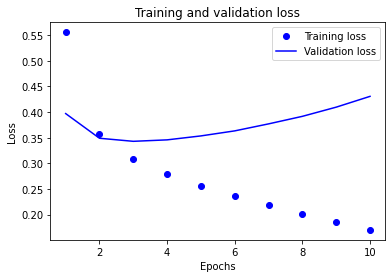

In [36]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

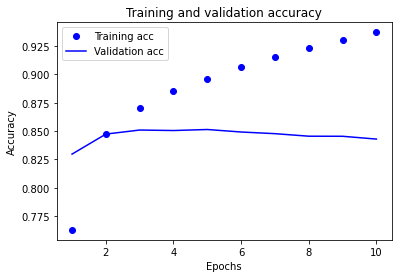

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 지금까지 학습된 Embedding 레이어 분석

In [38]:
# Embedding Layer의 가중치 파라미터
embedding_layer = model.layers[0]              # 위에서 나열한 레이어 중에 0번째 레이어 = embedding layer
weights = embedding_layer.get_weights()[0]     # embedding layer의 가중치들 얻기


print('Weights Shape: ', weights.shape)        # shape: (vocab_size, embedding_dim)
print('\nWeights 출력: \n', weights) 

Weights Shape:  (10000, 32)

Weights 출력: 
 [[-0.20738982 -0.13928267 -0.16002363 ... -0.13280499  0.36033374
  -0.16630305]
 [-0.04918641 -0.00723748  0.02599338 ... -0.01517115 -0.03478952
  -0.0420025 ]
 [ 0.0271386  -0.02054814  0.02402998 ... -0.01484183  0.01646999
  -0.01466706]
 ...
 [-0.0349405  -0.02378499  0.08300447 ... -0.02776217  0.00205655
  -0.04133816]
 [ 0.00166305 -0.02698503 -0.01610907 ...  0.02152006 -0.04705809
  -0.01075126]
 [ 0.02708365 -0.07772566 -0.03644475 ... -0.04056114 -0.03071603
   0.06324412]]


In [39]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_old_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_old_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))        # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
                                                                # 8-8에서 인덱스 0부터 3까지 <pad>, <bos>, <unk>, <unused> 4가지를 제외하기 위해 4를 뺌
                                                                # word_vector_dim: 임베딩 벡터의 차원수

# 단어 개수(에서 8-8의 <pad>, <bos>, <unk>, <unused> 문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]                                # embedding layer의 가중치들
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 **임베딩 파라미터 파일**을 읽어서 word vector로 활용할 수 있음

In [40]:
# 만들어 놓은 임베딩 파라미터 파일을 불러오기
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_old_file_path, binary=False)

# 임베딩 한 단어의 워드 벡터 출력해보기
vector = word_vectors['사랑']
vector

array([ 0.20607686,  0.01427934, -0.11119621, -0.1219725 ,  0.03177636,
       -0.13159274, -0.1355355 , -0.14497045, -0.1089448 ,  0.08366196,
        0.14452504, -0.1265953 , -0.0690963 ,  0.00508254, -0.04035954,
       -0.18436414, -0.11121186,  0.10056032, -0.0069699 , -0.07236877,
       -0.12240322, -0.13864243, -0.17983302,  0.05211749, -0.01937265,
        0.05071543, -0.12285902,  0.10556608, -0.1092369 , -0.04684676,
       -0.02837095, -0.1436291 ], dtype=float32)

In [41]:
# 유의어와 유사도 출력해보기
word_vectors.similar_by_word('사랑')

[('원빈', 0.7632746696472168),
 ('떠올리', 0.7454913854598999),
 ('줄리', 0.7386997938156128),
 ('맥스', 0.7250531315803528),
 ('!!!!', 0.7232670783996582),
 ('습', 0.7216807007789612),
 ('이연걸', 0.708609402179718),
 ('이안', 0.7049794793128967),
 ('챙겨', 0.7022815942764282),
 ('말코비치', 0.7019899487495422)]

> 사랑과 유의어를 출력해보니 유의어는 사랑과 관련성이 거의 없으며 유사도는 '원빈'이 가장 높다

# STEP 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요.   
또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 
[참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)


In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv("HOME") + "/data/word2vec_ko.model"
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv['사랑']
vector

array([ 3.2565942 , -0.85421413, -3.6964011 ,  1.0956469 ,  0.599815  ,
       -1.9681435 ,  0.32379073, -1.0716053 , -1.1776937 ,  2.0442047 ,
        2.2501915 , -2.7868037 , -2.702359  , -0.9775915 , -0.12478333,
        0.28235647,  0.77683175, -1.5393747 ,  2.0879042 , -5.444462  ,
       -4.931412  ,  0.8532094 ,  0.11118065, -2.743522  ,  0.7902363 ,
        0.10469969, -0.56074625,  1.6684421 ,  1.0278419 , -3.8816829 ,
       -3.606887  , -3.120771  , -1.2527398 , -0.77196646, -1.0102901 ,
        3.331668  ,  0.30032924,  1.2074511 , -1.2813627 ,  2.6281219 ,
       -1.4624823 , -1.1354805 ,  0.7605239 ,  2.83577   , -1.199358  ,
        3.1347232 ,  4.062026  , -0.23413125,  3.205856  , -0.9567054 ,
        0.77167803, -1.4300145 ,  2.9014013 , -3.940087  , -3.234169  ,
       -5.5460634 ,  0.6185009 , -0.75793767,  2.1043491 ,  2.350599  ,
        2.9313247 , -2.235593  ,  3.2084036 , -5.594638  ,  1.6516634 ,
       -0.32628602, -1.8824683 , -1.5573231 , -1.8452163 , -1.40

In [43]:
# 한 단어 당 100 차원 벡터
vector.shape

(100,)

In [44]:
# 302960 단어
len(word2vec.wv.key_to_index)

302960

> 이미 학습된 한글 word2vec은 단어 개수가 302,960 개

In [45]:
# 확인용
word2vec.wv.key_to_index

{'<': 34,
 'doc': 12,
 'id': 28,
 '="': 6,
 '5': 75,
 '"': 10,
 'url': 33,
 'https': 26,
 ':': 21,
 '/': 5,
 'ko': 32,
 '.': 0,
 'wikipedia': 31,
 'org': 27,
 'wiki': 30,
 '?': 24,
 'curid': 35,
 '=': 25,
 'title': 29,
 '지미': 5763,
 '카터': 7489,
 '">': 38,
 '제임스': 1377,
 '얼': 3574,
 '주니어': 3290,
 '(': 15,
 ',': 7,
 '1924': 2968,
 '년': 16,
 '10': 101,
 '월': 45,
 '1': 57,
 '일': 49,
 '~': 89,
 ')': 14,
 '는': 4,
 '민주당': 1170,
 '출신': 417,
 '미국': 105,
 '39': 2234,
 '대': 86,
 '대통령': 323,
 '1977': 1813,
 '1981': 1515,
 '이': 3,
 '다': 2,
 '생애': 484,
 '어린': 1470,
 '시절': 432,
 '조지': 1287,
 '아주': 1890,
 '섬터': 53673,
 '카운티': 1646,
 '플': 2029,
 '레인스': 48695,
 '마을': 642,
 '에서': 19,
 '태어났': 656,
 '조지아': 3586,
 '공과': 4556,
 '대학교': 228,
 '를': 17,
 '졸업': 679,
 '하': 11,
 '였': 51,
 '그': 53,
 '후': 106,
 '해군': 965,
 '에': 8,
 '들어가': 1081,
 '전함': 5183,
 '·': 99,
 '원자력': 3550,
 '잠수함': 3498,
 '의': 1,
 '승무원': 5176,
 '으로': 22,
 '1953': 2456,
 '대위': 6026,
 '로': 40,
 '예편': 13256,
 '고': 18,
 '이후': 107,
 '땅콩': 16441,
 '

In [46]:
# 유사도 확인 
word2vec.wv.similar_by_word('사랑')

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

> '사랑'과 유사도가 가장 높은 단어는 '이별'

## 이전 스텝에서 학습했던 모델의 임베딩 레이어를 이미 잘 학습된 한글 Word2Vec으로 교체하여 다시 학습시킴

In [47]:
vocab_size = 10000        # 기존에 만들었던 임베딩 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100     # 이미 학습된 한글 word2vec의 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)        # 아무 수로 embedding 행렬을 채움

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]           # 해당 단어의 Google Word2Vec에서 embedding 차원 벡터를 가져와 새롭게 만든 embedding행렬에 넣음

In [48]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000        # 기존에 만들었던 임베딩 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100     # 이미 학습된 한글 word2vec의 벡터의 차원수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))                        # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 128로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7                                     # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
227/227 [==============================] - 4s 13ms/step - loss: 0.4785 - accuracy: 0.7649 - val_loss: 0.3908 - val_accuracy: 0.8249
Epoch 2/7
227/227 [==============================] - 2s 11ms/step - loss: 0.3544 - accuracy: 0.8435 - val_loss: 0.3444 - val_accuracy: 0.8468
Epoch 3/7
227/227 [==============================] - 2s 11ms/step - loss: 0.3048 - accuracy: 0.8690 - val_loss: 0.3340 - val_accuracy: 0.8541
Epoch 4/7
227/227 [==============================] - 2s 11ms/step - loss: 0.2727 - accuracy: 0.8856 - val_loss: 0.3221 - val_accuracy: 0.8623
Epoch 5/7
227/227 [==============================] - 2s 11ms/step - loss: 0.2464 - accuracy: 0.8980 - val_loss: 0.3233 - val_accuracy: 0.8635
Epoch 6/7
227/227 [==============================] - 2s 11ms/step - loss: 0.2227 - accuracy: 0.9100 - val_loss: 0.3403 - val_accuracy: 0.8603
Epoch 7/7
227/227 [==============================] - 2s 11ms/step - loss: 0.1996 - accuracy: 0.9209 - val_loss: 0.3448 - val_accuracy: 0.8623


In [50]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3549 - accuracy: 0.8581
[0.3548921048641205, 0.8580670356750488]


# STEP 9. 회고

1. 이번 프로젝트에서 어려웠던 점 
    - 프로젝트 시작하기 전까지 읽어야 할 노드를 이해하는데 힘들었다
    - 실제 모델을 설정하고 정확도를 높이기까지 여러 방법을 시도했는데 결과를 달성하기가 너무 힘들었다
    - 모델 레이어를 쌓는 것이 실제로 많은 영향을 끼치는데 더 나은 방법을 찾는게 힘들었다

    
2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 많은 데이터로 학습된 word2vec이 가장 좋은 결과를 가져다 준다는 것을 알았다. 즉 데이터 품질이 좋아야 한다
    - 단어의 유의어와 유사도라는 개념을 알게 되었다
    - 3가지 모델 모두가 다른 결과값을 도출하였고 많은 방법이 있음을 알게 되었다


3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
    - 3가지 모델을 모두 사용해봤음
    - 필자가 만든 임베딩으로 한 것과 이미 잘 학습된 고급 word2vec을 받아서 모델을 학습시킨 것을 비교했다
    - 정확도 85%이상 달성했다

    
4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정  
    - 달성함

    
5. 자기 다짐
    - RNN의 개념은 이해했지만 실제로 적용해보니 어떻게 해야 정확도를 끌어올릴지 고민은 많이해봤다. 그러나 아직도 부족함을 느끼고 여러 자료들을 찾고 다시 시도해겠다
    
6. 3가지 모델
    - RNN 모델 : accuracy 0.8412
    - 1D CNN 모델 : accuracy 0.8296
    - GlobalMaxPooling1d 모델 : accuracy 0.8358
        
-> RNN모델이 가장 높아 한국어 Word2vec에서는 RNN 모델 선택함


7. 한국어 Word2Vec을 이용한 LSTM모델
- LSTM 출력 units을 8에서 128까지 변경하면서 시도했음
- epoch은 6-8정도에 손실값이 증가하는 경향을 보이기 때문에 6-10 사이에서만 값을 설정
- batchsize는 512로 고정했음

-> LSTM을 128로 했을 때 accuracy 0.8595를 달성함

    